In [86]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.stats.mstats import mquantiles
from  scipy.optimize import curve_fit as fit

import copy as cp
import sys
import os
sys.path.append(os.path.abspath('../Backend'))

import wahlrecht_polling_firms
import model_helper
from preprocessing import average as average
%matplotlib inline

In [87]:
complete_data_dict = wahlrecht_polling_firms.get_tables()
data = complete_data_dict['allensbach']

#data = average(data,'weightparticipants')
data

,Datum,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Befragte
0,2017-06-20,40.0,24.0,7.0,10.5,8.5,6.5,3.5,1437.0
1,2017-05-26,37.0,26.0,8.0,9.0,8.0,8.0,4.0,1457.0
2,2017-04-25,36.0,31.0,7.0,6.0,9.0,7.0,4.0,1407.0
3,2017-03-28,34.0,33.0,7.5,6.5,8.0,7.0,4.0,1397.0
4,2017-02-22,33.0,30.5,8.0,7.0,8.0,8.5,5.0,1542.0
5,2017-01-26,36.0,23.0,9.0,7.0,9.5,11.5,4.0,1441.0
6,2016-12-22,35.5,22.0,10.0,7.5,9.5,10.5,5.0,1459.0
7,2016-11-16,34.0,23.0,11.0,7.5,9.0,10.5,5.0,1436.0
8,2016-10-20,33.0,22.0,12.0,7.5,9.0,12.5,4.0,1458.0
9,2016-09-22,33.5,24.0,11.0,7.0,7.0,12.5,5.0,1407.0


In [204]:
class predict_till_election ():
    '''
    Each model gives 2 outputs: the traces for the parties, and the quantiles at 5%, 50% and 95%.
    **kwargs : "weeks" how many weeks back in the past are used
    
    '''
    
    def __init__ (self, timeline = data, predict_f = 'montecarlo'):
        
        self.timeline = timeline
        self.funcs_dict = {'montecarlo': self.montecarlo,
                           'linear': self.linear,
                           'quadratic': self.quadratic}
        self.predict_f = self.funcs_dict[predict_f]
        self.election_date = pd.to_datetime('24.09.2017') #dt.date.strptime('24.09.2017', '%d.%m.%Y')
        self.weeks_left(timeline)
        self.parties  = np.array(model_helper.parties)
        self.result = []
    
    def predict(self, **kwargs):
        self.predict_f(**kwargs)
        self.make_result()
        
    def make_result(self):
        
        dates = self.timeline.Datum[0] +np.array([dt.timedelta(weeks=i) for i in range(self.weeks) ])
        
        self.result = pd.DataFrame(columns= self.parties, index= range(self.weeks))
        
        for i,party in enumerate(self.parties):
            for j in range(len(self.quantiles[i].T)):
                
                self.result[party].iloc[j] = self.quantiles[i].T[j]
        self.result.insert(0,'Datum',dates)

        
    def weeks_left(self, timeline):
        most_recent_poll = self.election_date  - pd.to_datetime (timeline['Datum']) #TODO: make sure it's always "Datum"
        
        self.weeks = int((most_recent_poll).astype('timedelta64[W]')[0])
    
    def montecarlo(self, iterations = 1000, **kwargs):
        self.help_timeline=  cp.deepcopy(self.timeline[self.parties]).applymap(lambda x: x[1])
        #print ((iterations,self.weeks,len(self.parties)))
        self.traces = np.empty ((iterations,self.weeks,len(self.parties)))
        
        covar = self.help_timeline[self.parties].cov()

        for i in range(iterations):
            self.traces[i] =self.n_weeks_predict(covar)
            #if (100*i/iterations) == int ((100*i/iterations)):
            #    print ("\r %d" %(100*i/iterations), end = '')
        #print("\r 100%")
        self.quantiles = np.array([mquantiles(test.traces[:,:,i], prob = (0.05,0.5,0.95), axis= 0) for i in range(len(self.parties))])

        
        
    def n_weeks_predict (self, covar):
        trace = np.empty((self.weeks,len(self.parties)))
        
        props = self.help_timeline[self.parties].iloc[0]
        trace [0] = props
        
        for i in range (1,self.weeks):
            props+=np.random.multivariate_normal(np.zeros(len(self.parties)) , covar)
            props[props<0]=0
            props= props/(props.sum()) *100
            trace[i] = props
        return trace
    
    def linear (self,**kwargs):
        # TODO : make sure that the self.quantiles is getting 3 point as a prediction for 
        #the linear model for each party for each time point, it works with .reshape(len(self.parties),1)
        self.traces = None
        self.quantiles = np.zeros((len(self.parties),3,self.weeks))
        helper = [self.timeline.iloc[0][party] for party in self.parties]
        for i in range(len(self.parties)):
            
            self.quantiles[i] = np.tile(np.array(helper)[i][:],13).reshape(13,-1).T
        #self.quantiles = np.tile(self.quantiles,self.weeks).reshape(len(self.parties),3,self.weeks)
        #self.quantiles = np.tile(self.timeline.iloc[0][self.parties].reshape(len(self.parties),3,-1), (1,self.weeks))
        
    def quadratic (self, **kwargs):
        if 'weeks' in kwargs:
            weeks = kwargs['weeks']
        else :
            weeks = -1
            
        popts = np.zeros((3, len(self.timeline.iloc[:weeks])))
        quad = lambda x,a,b,c : a +x*b+ c*x**2  
        self.traces = []
        
        for ind, party in enumerate( self.parties):
            popt, pcovs = fit(quad,np.arange(len(self.timeline.iloc[:weeks][party])),self.timeline.iloc[:weeks][party])

            self.traces.append(quad(np.arange(-self.weeks,len(self.timeline[party])),*popt) )
            
        self.traces = np.array(self.traces)
        #self.quantiles = 

In [205]:
newdf = cp.deepcopy(data)
newdf[model_helper.parties] =newdf[model_helper.parties].applymap(lambda x : [-2+x,x,x+2])





In [208]:
test = predict_till_election(timeline=newdf,predict_f='linear')

In [209]:
test.predict(iterations=100)

In [211]:
newdf

,Datum,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Befragte
0,2017-06-20,"[38.0, 40.0, 42.0]","[22.0, 24.0, 26.0]","[5.0, 7.0, 9.0]","[8.5, 10.5, 12.5]","[6.5, 8.5, 10.5]","[4.5, 6.5, 8.5]","[1.5, 3.5, 5.5]",1437.0
1,2017-05-26,"[35.0, 37.0, 39.0]","[24.0, 26.0, 28.0]","[6.0, 8.0, 10.0]","[7.0, 9.0, 11.0]","[6.0, 8.0, 10.0]","[6.0, 8.0, 10.0]","[2.0, 4.0, 6.0]",1457.0
2,2017-04-25,"[34.0, 36.0, 38.0]","[29.0, 31.0, 33.0]","[5.0, 7.0, 9.0]","[4.0, 6.0, 8.0]","[7.0, 9.0, 11.0]","[5.0, 7.0, 9.0]","[2.0, 4.0, 6.0]",1407.0
3,2017-03-28,"[32.0, 34.0, 36.0]","[31.0, 33.0, 35.0]","[5.5, 7.5, 9.5]","[4.5, 6.5, 8.5]","[6.0, 8.0, 10.0]","[5.0, 7.0, 9.0]","[2.0, 4.0, 6.0]",1397.0
4,2017-02-22,"[31.0, 33.0, 35.0]","[28.5, 30.5, 32.5]","[6.0, 8.0, 10.0]","[5.0, 7.0, 9.0]","[6.0, 8.0, 10.0]","[6.5, 8.5, 10.5]","[3.0, 5.0, 7.0]",1542.0
5,2017-01-26,"[34.0, 36.0, 38.0]","[21.0, 23.0, 25.0]","[7.0, 9.0, 11.0]","[5.0, 7.0, 9.0]","[7.5, 9.5, 11.5]","[9.5, 11.5, 13.5]","[2.0, 4.0, 6.0]",1441.0
6,2016-12-22,"[33.5, 35.5, 37.5]","[20.0, 22.0, 24.0]","[8.0, 10.0, 12.0]","[5.5, 7.5, 9.5]","[7.5, 9.5, 11.5]","[8.5, 10.5, 12.5]","[3.0, 5.0, 7.0]",1459.0
7,2016-11-16,"[32.0, 34.0, 36.0]","[21.0, 23.0, 25.0]","[9.0, 11.0, 13.0]","[5.5, 7.5, 9.5]","[7.0, 9.0, 11.0]","[8.5, 10.5, 12.5]","[3.0, 5.0, 7.0]",1436.0
8,2016-10-20,"[31.0, 33.0, 35.0]","[20.0, 22.0, 24.0]","[10.0, 12.0, 14.0]","[5.5, 7.5, 9.5]","[7.0, 9.0, 11.0]","[10.5, 12.5, 14.5]","[2.0, 4.0, 6.0]",1458.0
9,2016-09-22,"[31.5, 33.5, 35.5]","[22.0, 24.0, 26.0]","[9.0, 11.0, 13.0]","[5.0, 7.0, 9.0]","[5.0, 7.0, 9.0]","[10.5, 12.5, 14.5]","[3.0, 5.0, 7.0]",1407.0


In [177]:

for i in range(7):
    print(.shape)

(13, 3)
(13, 3)
(13, 3)
(13, 3)
(13, 3)
(13, 3)
(13, 3)


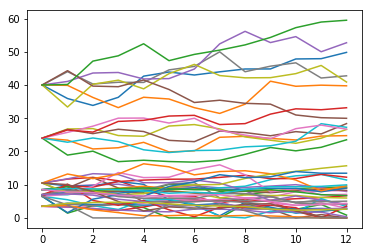

In [126]:
for i in range (7):
    plt.plot(test.traces[i][:])

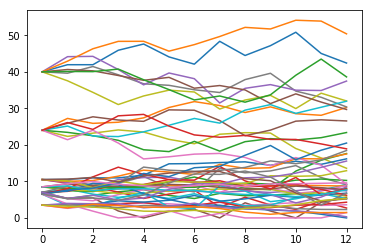

In [118]:
for i in range (7):
    plt.plot(test.traces[i][:])

In [81]:
newdf

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,"[40.0, 40.0, 40.0]","[24.0, 24.0, 24.0]","[7.0, 7.0, 7.0]","[10.5, 10.5, 10.5]","[8.5, 8.5, 8.5]","[6.5, 6.5, 6.5]","[3.5, 3.5, 3.5]"
1,"[35.7774404986, 40.2876191513, 44.9534171819]","[20.0288699447, 24.4603740171, 27.9870480175]","[5.09983670603, 7.1322854961, 9.01294723675]","[7.48870897184, 10.1443141427, 12.7996027638]","[7.43801977417, 8.4336378014, 9.36553850007]","[1.98131432973, 6.21481545468, 9.88085319179]","[2.74503866744, 3.60569981483, 4.5576315723]"
2,"[33.2280585033, 39.6102368704, 47.26999]","[18.1638014049, 23.903785624, 28.7652296186]","[4.47163233817, 7.19976963363, 9.78955988249]","[6.73085490176, 10.1735816466, 13.7176358494]","[7.0776167114, 8.37023890701, 9.69489777262]","[0.999499488826, 6.52563800288, 12.5945143671]","[2.18739082456, 3.54971507985, 5.01544059031]"
3,"[32.0451702968, 40.1767319516, 47.8007902759]","[17.7472205029, 23.5865336706, 30.0035480325]","[4.64327927862, 7.05620689651, 10.3400745374]","[5.98912737944, 10.2385954167, 14.7049003478]","[6.86428015246, 8.35513401023, 10.1764255999]","[0.0, 6.36960948212, 13.4516039074]","[2.00253196189, 3.65261026778, 5.40260068742]"
4,"[28.3442182029, 39.8769967134, 48.1685291916]","[16.6461724829, 23.3379414399, 30.9212688382]","[4.03499272131, 7.13693545824, 10.5722503032]","[5.61102808633, 10.8372445141, 15.5903695665]","[6.61888455402, 8.43152506208, 10.1527361849]","[0.0, 6.3968174611, 15.3164999643]","[1.74325066633, 3.68034235989, 5.54633834799]"
5,"[28.656522655, 41.0456870244, 51.0372327792]","[16.7879699803, 23.1754177491, 31.4737910306]","[3.74506516749, 7.02611055689, 10.8579264828]","[3.88461288944, 10.18622672, 16.4491569145]","[6.16301305813, 8.31992990255, 10.2048995765]","[0.0, 6.01236018027, 16.549762843]","[1.74363277147, 3.62384380606, 5.64398096582]"
6,"[26.8662711399, 40.0772760224, 50.6434230446]","[15.7579195013, 23.5086200888, 33.3474667969]","[3.11295260966, 6.46471146832, 11.3683814629]","[3.81047655222, 10.2572541285, 17.1541947377]","[6.18249721601, 8.46568963924, 10.3441703521]","[0.0, 7.01086202834, 16.4038639362]","[1.29837722126, 3.56361763873, 6.23977740391]"
7,"[28.5904873286, 40.3355817696, 51.3038689583]","[14.9532766216, 23.7813732618, 34.0835001782]","[1.77362804742, 6.85551318145, 11.8951668655]","[2.66538505168, 10.3306969519, 16.8142545815]","[6.08008107874, 8.52705959492, 10.6019710764]","[0.0, 6.23475007356, 16.5232039658]","[1.07873962615, 3.45567005644, 6.27074917733]"
8,"[27.5208186747, 39.5217711792, 51.2423561756]","[14.8980319683, 24.5140808227, 35.1941113528]","[1.73922172515, 6.56741272671, 11.6691707492]","[1.37252149594, 10.1091368462, 17.6248987618]","[6.02821319897, 8.49282633279, 11.051274008]","[0.0, 6.13837415988, 17.8452410331]","[0.788670467022, 3.3432151465, 6.47109490667]"
9,"[26.2914403063, 39.7817274016, 52.4826687941]","[13.9623786177, 25.1267064407, 34.8065937339]","[1.24594180254, 6.56836788676, 12.5576732616]","[2.63014209387, 10.1567532418, 16.9684878692]","[6.07215554367, 8.53529470588, 11.5654236158]","[0.0, 6.19225975423, 19.1774122932]","[0.54426345089, 3.41289906076, 6.40892379333]"


In [83]:
newdf

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,"[40.0, 40.0, 40.0]","[24.0, 24.0, 24.0]","[7.0, 7.0, 7.0]","[10.5, 10.5, 10.5]","[8.5, 8.5, 8.5]","[6.5, 6.5, 6.5]","[3.5, 3.5, 3.5]"
1,"[35.7774404986, 40.2876191513, 44.9534171819]","[20.0288699447, 24.4603740171, 27.9870480175]","[5.09983670603, 7.1322854961, 9.01294723675]","[7.48870897184, 10.1443141427, 12.7996027638]","[7.43801977417, 8.4336378014, 9.36553850007]","[1.98131432973, 6.21481545468, 9.88085319179]","[2.74503866744, 3.60569981483, 4.5576315723]"
2,"[33.2280585033, 39.6102368704, 47.26999]","[18.1638014049, 23.903785624, 28.7652296186]","[4.47163233817, 7.19976963363, 9.78955988249]","[6.73085490176, 10.1735816466, 13.7176358494]","[7.0776167114, 8.37023890701, 9.69489777262]","[0.999499488826, 6.52563800288, 12.5945143671]","[2.18739082456, 3.54971507985, 5.01544059031]"
3,"[32.0451702968, 40.1767319516, 47.8007902759]","[17.7472205029, 23.5865336706, 30.0035480325]","[4.64327927862, 7.05620689651, 10.3400745374]","[5.98912737944, 10.2385954167, 14.7049003478]","[6.86428015246, 8.35513401023, 10.1764255999]","[0.0, 6.36960948212, 13.4516039074]","[2.00253196189, 3.65261026778, 5.40260068742]"
4,"[28.3442182029, 39.8769967134, 48.1685291916]","[16.6461724829, 23.3379414399, 30.9212688382]","[4.03499272131, 7.13693545824, 10.5722503032]","[5.61102808633, 10.8372445141, 15.5903695665]","[6.61888455402, 8.43152506208, 10.1527361849]","[0.0, 6.3968174611, 15.3164999643]","[1.74325066633, 3.68034235989, 5.54633834799]"
5,"[28.656522655, 41.0456870244, 51.0372327792]","[16.7879699803, 23.1754177491, 31.4737910306]","[3.74506516749, 7.02611055689, 10.8579264828]","[3.88461288944, 10.18622672, 16.4491569145]","[6.16301305813, 8.31992990255, 10.2048995765]","[0.0, 6.01236018027, 16.549762843]","[1.74363277147, 3.62384380606, 5.64398096582]"
6,"[26.8662711399, 40.0772760224, 50.6434230446]","[15.7579195013, 23.5086200888, 33.3474667969]","[3.11295260966, 6.46471146832, 11.3683814629]","[3.81047655222, 10.2572541285, 17.1541947377]","[6.18249721601, 8.46568963924, 10.3441703521]","[0.0, 7.01086202834, 16.4038639362]","[1.29837722126, 3.56361763873, 6.23977740391]"
7,"[28.5904873286, 40.3355817696, 51.3038689583]","[14.9532766216, 23.7813732618, 34.0835001782]","[1.77362804742, 6.85551318145, 11.8951668655]","[2.66538505168, 10.3306969519, 16.8142545815]","[6.08008107874, 8.52705959492, 10.6019710764]","[0.0, 6.23475007356, 16.5232039658]","[1.07873962615, 3.45567005644, 6.27074917733]"
8,"[27.5208186747, 39.5217711792, 51.2423561756]","[14.8980319683, 24.5140808227, 35.1941113528]","[1.73922172515, 6.56741272671, 11.6691707492]","[1.37252149594, 10.1091368462, 17.6248987618]","[6.02821319897, 8.49282633279, 11.051274008]","[0.0, 6.13837415988, 17.8452410331]","[0.788670467022, 3.3432151465, 6.47109490667]"
9,"[26.2914403063, 39.7817274016, 52.4826687941]","[13.9623786177, 25.1267064407, 34.8065937339]","[1.24594180254, 6.56836788676, 12.5576732616]","[2.63014209387, 10.1567532418, 16.9684878692]","[6.07215554367, 8.53529470588, 11.5654236158]","[0.0, 6.19225975423, 19.1774122932]","[0.54426345089, 3.41289906076, 6.40892379333]"


In [95]:
newdf

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,40.0,24.0,7.0,10.5,8.5,6.5,3.5
1,37.0,26.0,8.0,9.0,8.0,8.0,4.0
2,36.0,31.0,7.0,6.0,9.0,7.0,4.0
3,34.0,33.0,7.5,6.5,8.0,7.0,4.0
4,33.0,30.5,8.0,7.0,8.0,8.5,5.0
5,36.0,23.0,9.0,7.0,9.5,11.5,4.0
6,35.5,22.0,10.0,7.5,9.5,10.5,5.0
7,34.0,23.0,11.0,7.5,9.0,10.5,5.0
8,33.0,22.0,12.0,7.5,9.0,12.5,4.0
9,33.5,24.0,11.0,7.0,7.0,12.5,5.0


In [112]:
test.quantiles2.SPD.iloc[[2]] = np.array([1,2,3])

ValueError: cannot set using a list-like indexer with a different length than the value

array([datetime.date(2017, 6, 20), datetime.date(2017, 6, 27),
       datetime.date(2017, 7, 4), datetime.date(2017, 7, 11),
       datetime.date(2017, 7, 18), datetime.date(2017, 7, 25),
       datetime.date(2017, 8, 1), datetime.date(2017, 8, 8),
       datetime.date(2017, 8, 15), datetime.date(2017, 8, 22),
       datetime.date(2017, 8, 29), datetime.date(2017, 9, 5),
       datetime.date(2017, 9, 12)], dtype=object)

In [29]:
df = pd.DataFrame(columns=test.parties, index=[0])
#df[test.parties][0] = [0, 0]
df

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
data.insert(0,'Datum2',data.Datum)

In [49]:
test.quantiles.shape

(7, 3, 13)

In [159]:
plt.scatter(data.Datum,data.SPD)

TypeError: float() argument must be a string or a number, not 'datetime.date'

TypeError: float() argument must be a string or a number, not 'datetime.date'